## Notes on Conversion from Lat/Lon Coordinates to UTM coordinates

1. Lat/Lon given with uniform spacing in terms of degrees. This is misleading because this does not correspond to uniform spacing spatially. (without uniform spacing spatially it is difficult to compute gradients / orientations) 
2. There is a nonlinearity in the mapping between Lat/Lon and UTM northings and eastings. Given a constant value for Lat (with varying Lon), both the easting and northing change (instead of just easting). This makes the conversion to uniform spacing non-trivial because you cannot just "stretch" the bathymetry array
3. It is inefficient to store all values in the resulting UTM coordinate matrix. Since the bathymetry is provided as 10m gridding, the input (dense) matrix is ~$2*10^6$ entries. For the full spatial extent in UTM with 1m spacing, the sparse matrix would be of size ~$2*10^8$ entries, or a factor of 100 times larger than the input -- this is computationally inefficient. This motivates the use of a pandas DataFrame instead of using default numpy array because Pandas DataFrame you explicitly keep track of x-coordinate and y-coordinate as seperate columns (still sparse) and still have ability to perform filtering on features (such as on depth/slope/orientation/position)


## TODO

Working for kolumbo .tif files which is good.

Can read in puerto rico .tif but there seems to be a problem due to size, and also something deeper that is the same problem for both puerto rico and buzz bay.

bathy height and width for kolumbo
(1479, 1342)

for puerto rico 6-7x bigger
but when i did a test of (100,100) the plots made no sense

# Plotting Bathymetric Data in Python

In [1]:
import seaborn as sns 
import numpy as np
import rasterio as rio
import importlib
import pandas as pd
import earthpy as et
import earthpy.plot as ep
import scipy
import scipy.signal
import os
import sys
import utm
from scipy import interpolate
from scipy.interpolate import RectBivariateSpline

sys.path.insert(1, os.path.join(sys.path[0], '../data'))
sys.path.append(os.path.join(sys.path[0], '../'))

import warnings
warnings.simplefilter('ignore')

import BathymetryMap
import bathy_meta_data
from matplotlib import pyplot as plt 
from PIL import Image
def reload_modules():
    importlib.reload(bathy_meta_data)
    importlib.reload(BathymetryMap)

## Load Data

In [2]:
reload_modules()
meta_dict = bathy_meta_data.BathyData["Puerto_Rico"]
#meta_dict = bathy_meta_data.BathyData["BuzzardsBay"]
# meta_dict = bathy_meta_data.BathyData["Kolumbo_full"]
bathy     = BathymetryMap.BathymetryMap(meta_dict=meta_dict)
bathy.parse_bathy_file()


<Figure size 432x288 with 0 Axes>

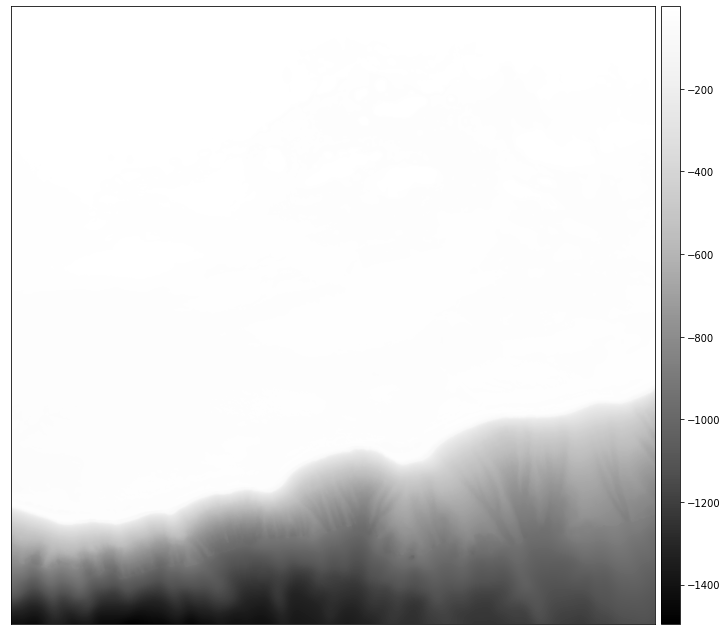

<AxesSubplot:>

In [3]:
plt.figure()
ep.plot_bands(
    bathy.bathy
)

In [9]:
bathy.bounds

BoundingBox(left=-67.2501851852, bottom=17.7498148148, right=-66.74981481477043, top=18.0001851852)

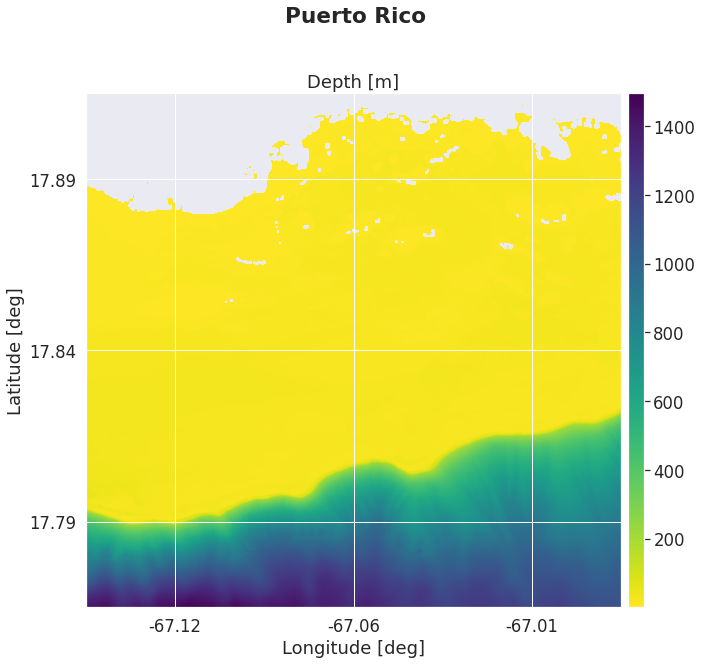

In [4]:
bathy.plot_depth_map()

In [8]:
print(bathy.width, bathy.height)

11500 6000


In [26]:
print(bathy.left, bathy.right, bathy.top, bathy.bottom)

delta_lon = (bathy.right - bathy.left)/bathy.width
delta_lat = (bathy.top   - bathy.bottom)/bathy.height

delta_lon, delta_lat

25.366617000001263 25.516716996209418 36.633349996631296 36.49995000000126


(0.00011184798525197843, 9.019607615282796e-05)

In [27]:
bathy.height, bathy.width

(1479, 1342)

---
## Create Bathymetric and Variance Maps at Differing Resolutions
One thing to note, from testing, the TAN process only seems to work with the original 10m resolution map. However, where the algorithm queries the variance for the estimated location, the lower resolution maps can be plugged in. It was found that a 20 m "variance map" had the best results. 

In [5]:
# map is at 10 m resolution, will divide num of grid points by numbers in "resolutions" 
# --> resulting in maps with resolution at 20m, 40m, 60m, 80m, and 100m
#resolutions = [2, 4, 6, 8, 10]
resolutions = [1, 2]
save_maps = True
plot_true = True

# Initial Parsing
x_coords = []
y_coords = [] 

corners =  [
    (bathy.top,    bathy.left), 
    (bathy.bottom, bathy.left), 
    (bathy.bottom, bathy.right),
    (bathy.top,    bathy.right)
]

for (lat,lon) in corners:
    x,y,_,_ = utm.from_latlon(lat,lon)
    x_coords.append(int(np.round(x)))
    y_coords.append(int(np.round(y)))

x_min = min(x_coords)
x_max = max(x_coords)
y_min = min(y_coords)
y_max = max(y_coords)
x_rng = x_max - x_min 
y_rng = y_max - y_min

# if M is (nxn), function returns a (nxn) matrix where each point represents the variance of the original point based on 8 surrounding points
def calculateVar_pts_in_matrix(M):
    var_matrix = np.zeros((len(M[:,0]), len(M[0,:])))
    for i in range(1,len(M[:,0])-1):       #for all rows except first and last
        for j in range(1,len(M[0,:])-1):   #for all columns except first and last
            pts = np.array([ M[i,j] , M[i+1, j] , M[i+1, j-1], M[i+1,j+1], M[i,j+1], M[i, j-1], M[i-1, j], M[i-1, j+1], M[i-1, j-1]])
            var_matrix[i,j] = np.var(pts)
    #Set Equal edges to inside rows
    var_matrix[:,0] = var_matrix[:,1]
    var_matrix[:,len(M[0,:])-1] = var_matrix[:,len(M[0,:]) - 2]
    var_matrix[0,:] = var_matrix[1,:]
    var_matrix[len(M[:,0])-1, :] = var_matrix[len(M[:,0]) - 2,:]
    return(var_matrix)


In [6]:
bathy_orient_normMap = np.zeros((bathy.height, bathy.width))
for i in range(bathy.width):
    for j in range(bathy.height):
        if bathy.orient[j, i] < 0:
            bathy_orient_normMap[j,i] = bathy.orient[j,i] + 360
        else:
            bathy_orient_normMap[j,i] = bathy.orient[j,i]

In [7]:
for resolution in resolutions:
    depth_var_list  = []
    slope_var_list  = []
    orient_var_list = []
    utm_x_list      = []
    utm_y_list      = [] 
    depth_list      = []
    slope_list      = []
    orient_list     = []
    
    y        = np.linspace(bathy.top, bathy.bottom, bathy.height)
    x        = np.linspace(bathy.left, bathy.right, bathy.width)
    f_depth  = interpolate.interp2d(x,y ,bathy.depth, kind='linear')
    f_slope  = interpolate.interp2d(x,y ,bathy.slope, kind='linear')
    f_orient =interpolate.interp2d(x,y ,bathy_orient_normMap, kind='linear')

    x_new = np.linspace(bathy.left, bathy.right, int(bathy.width/resolution))
    y_new = np.linspace(bathy.top, bathy.bottom, int(bathy.height/resolution))

    new_bathy_depth = f_depth(x_new,y_new)
    new_bathy_slope = f_slope(x_new,y_new)
    new_bathy_orient = f_orient(x_new,y_new)    
    
    depth_var  = calculateVar_pts_in_matrix(new_bathy_depth)
    slope_var  = calculateVar_pts_in_matrix(new_bathy_slope)
    orient_var = calculateVar_pts_in_matrix(new_bathy_orient)
    # j = 0       -->  top side 
    # j = height  -->  bottom side
    # i = 0       -->  left side 
    # i = width   -->  right side
    
    #Convert orientation map back to [-180 180]
    bathy_orient_map2 = np.zeros((int(bathy.height/resolution), int(bathy.width/resolution)))
    for i in range(int(bathy.width/resolution)):
        for j in range(int(bathy.height/resolution)):
            if new_bathy_orient[j, i] > 180:
                bathy_orient_map2[j,i] = new_bathy_orient[j,i] - 360
            else:
                bathy_orient_map2[j,i] = new_bathy_orient[j,i]
    
    for i in range(int(bathy.width/resolution)):
        for j in range(int(bathy.height/resolution)):
            # extract relevant variables from the bathymetry array
            lat = bathy.top  + ((bathy.bottom-bathy.top) /int(bathy.height/resolution))*j
            lon = bathy.left + ((bathy.right -bathy.left)/int(bathy.width/resolution)) *i
            utm_x, utm_y, _, _ = utm.from_latlon(lat, lon)

            cur_depth  = new_bathy_depth[j, i]
            cur_slope  = new_bathy_slope[j, i]
            cur_orient = bathy_orient_map2[j, i]
            cur_depth_var  = depth_var[j, i]
            cur_slope_var  = slope_var[j, i]
            cur_orient_var = orient_var[j, i]

            depth_var_list.append(cur_depth_var)
            slope_var_list.append(cur_slope_var)
            orient_var_list.append(cur_orient_var)
            utm_x_list.append(utm_x)
            utm_y_list.append(utm_y)
            depth_list.append(cur_depth)
            slope_list.append(cur_slope)
            orient_list.append(cur_orient)
                           
    bathy_data = {
        'utm_x_list'  : utm_x_list,
        'utm_y_list'  : utm_y_list,
        'depth_list'  : depth_list,
        'slope_list'  : slope_list,
        'orient_list' : orient_list,
        'depth_var'   : depth_var_list,
        'slope_var'   : slope_var_list,
        'orient_var'  : orient_var_list,
        }

    bathy_df = pd.DataFrame.from_dict(bathy_data)
    #Kolumbo                      
    # y_min = 4.041e6
    # y_max = 4.051e6
    # x_min = 3.610e5
    # x_max = 3.670e5
    
    #Puerto Rico
    # y_min = 1968750
    # y_max = 1988161
    # x_min = 688590
    # x_max = 726762

    # bathy_sub_df = bathy_df[(bathy_df.utm_x_list < x_max) & 
    #                         (bathy_df.utm_x_list > x_min) &
    #                         (bathy_df.utm_y_list < y_max) & 
    #                         (bathy_df.utm_y_list > y_min)]
    bathy_sub_df = bathy_df
    if save_maps:
        outFileName = '/home/gburgess/dvl-nav/data/field_data/puerto_rico/bathy/puertoRico-' + str(resolution)
        bathy_sub_df.to_csv(outFileName+".csv", sep=',', index=False)
    
    if plot_true:
        fig,ax=plt.subplots(figsize=(10,10))
        sns.scatterplot(
            bathy_sub_df.utm_x_list,
            bathy_sub_df.utm_y_list,
            bathy_sub_df.slope_list,
            palette='inferno_r',
            linewidth=0,
            legend=False)
        plt.axis('equal')
        plt.title('Slope %s'%str(resolution) + '0m Map Resolution')
        #plt.savefig('/Users/zduguid/Desktop/fig/tmp.png')
        #plt.close()
        
        fig,ax=plt.subplots(figsize=(10,10))
        sns.scatterplot(
            bathy_sub_df.utm_x_list,
            bathy_sub_df.utm_y_list,
            bathy_sub_df.slope_var,
            palette='inferno_r',
            linewidth=0,
            legend=False)
        plt.axis('equal')
        plt.title('Slope Var %s'%str(resolution) + '0m Map Resolution')


        fig,ax=plt.subplots(figsize=(10,10))
        sns.scatterplot(
            bathy_sub_df.utm_x_list,
            bathy_sub_df.utm_y_list,
            bathy_sub_df.orient_list,
            palette='viridis_r',
            linewidth=0,
            legend=False)
        plt.axis('equal')
        plt.title('Orientation %s'%str(resolution) + '0m Map Resolution')
        #plt.savefig('/Users/zduguid/Desktop/fig/tmp.png')
        #plt.close()
        
        fig,ax=plt.subplots(figsize=(10,10))
        sns.scatterplot(
            bathy_sub_df.utm_x_list,
            bathy_sub_df.utm_y_list,
            bathy_sub_df.orient_var,
            palette='viridis_r',
            linewidth=0,
            legend=False)
        plt.axis('equal')
        plt.title('Orientation Var %s'%str(resolution) + '0m Map Resolution')
        #plt.savefig('/Users/zduguid/Desktop/fig/tmp.png')
        #plt.close()

        fig,ax=plt.subplots(figsize=(10,10))
        sns.scatterplot(
            bathy_sub_df.utm_x_list,
            bathy_sub_df.utm_y_list,
            bathy_sub_df.depth_list,
            palette='twilight_shifted',
            linewidth=0,
            legend=False)
        plt.axis('equal')
        plt.title('Depth %s'%str(resolution) + '0m Map Resolution')
        #plt.savefig('/Users/zduguid/Desktop/fig/tmp.png')
        #plt.close()
        
        fig,ax=plt.subplots(figsize=(10,10))
        sns.scatterplot(
            bathy_sub_df.utm_x_list,
            bathy_sub_df.utm_y_list,
            bathy_sub_df.depth_var,
            palette='twilight_shifted',
            linewidth=0,
            legend=False)
        plt.axis('equal')
        plt.title('Depth var %s'%str(resolution) + '0m Map Resolution')
        #plt.savefig('/Users/zduguid/Desktop/fig/tmp.png')
        #plt.close()

---
## Initial Bathy Plotting Work (Consolidated above)
### Data Parsing 

In [ ]:
x_coords = []
y_coords = [] 

corners =  [
    (bathy.top,    bathy.left), 
    (bathy.bottom, bathy.left), 
    (bathy.bottom, bathy.right),
    (bathy.top,    bathy.right)
]

for (lat,lon) in corners:
    x,y,_,_ = utm.from_latlon(lat,lon)
    x_coords.append(int(np.round(x)))
    y_coords.append(int(np.round(y)))

x_min = min(x_coords)
x_max = max(x_coords)
y_min = min(y_coords)
y_max = max(y_coords)
x_rng = x_max - x_min 
y_rng = y_max - y_min
# print(x_rng)
# print(y_rng)
# print(x_rng*y_rng)
# print(x_coords)
# print(y_coords)

NameError: name 'bathy' is not defined

In [ ]:
utm_x_list      = []
utm_y_list      = [] 
depth_list      = []
slope_list      = []
orient_list     = []


# j = 0       -->  top side 
# j = height  -->  bottom side
# i = 0       -->  left side 
# i = width   -->  right side
for i in range(bathy.width):
    for j in range(bathy.height):
        # extract relevant variables from the bathymetry array
        lat = bathy.top  + ((bathy.bottom-bathy.top) /bathy.height)*j
        lon = bathy.left + ((bathy.right -bathy.left)/bathy.width) *i
        utm_x, utm_y, _, _ = utm.from_latlon(lat, lon)
        cur_depth  = bathy.depth[j, i]
        cur_slope  = bathy.slope[j, i]
        cur_orient = bathy.orient[j, i]
        
#         cur_depth_var  = depth_var[j, i]
#         cur_slope_var  = slope_var[j, i]
#         cur_orient_var = orient_var[j, i]
        
        utm_x_list.append(utm_x)
        utm_y_list.append(utm_y)
        depth_list.append(cur_depth)
        slope_list.append(cur_slope)
        orient_list.append(cur_orient)


In [ ]:
print(np.shape(bathy.depth))
print(np.shape(bathy.slope))
print(np.shape(bathy.orient))

(1479, 1342)
(1479, 1342)
(1479, 1342)


### Calculate Variance of Factor Maps

In [ ]:
# if M is (nxn), function returns a (nxn) matrix where each point represents the variance of the original point based on 8 surrounding points
def calculateVar_pts_in_matrix(M):
    var_matrix = np.zeros((len(M[:,0]), len(M[0,:])))
    for i in range(1,len(M[:,0])-1):       #for all rows except first and last
        for j in range(1,len(M[0,:])-1):   #for all columns except first and last
            pts = np.array([ M[i,j] , M[i+1, j] , M[i+1, j-1], M[i+1,j+1], M[i,j+1], M[i, j-1], M[i-1, j], M[i-1, j+1], M[i-1, j-1]])
            var_matrix[i,j] = np.var(pts)
    #Set Equal edges to inside rows
    var_matrix[:,0] = var_matrix[:,1]
    var_matrix[:,len(M[0,:])-1] = var_matrix[:,len(M[0,:]) - 2]
    var_matrix[0,:] = var_matrix[1,:]
    var_matrix[len(M[:,0])-1, :] = var_matrix[len(M[:,0]) - 2,:]
    return(var_matrix)



## Normalaize Orientation Map to [0, 360] from [-180 180]
bathy_orient_normMap = np.zeros((bathy.height, bathy.width))
for i in range(bathy.width):
    for j in range(bathy.height):
        if bathy.orient[j, i] < 0:
            bathy_orient_normMap[j,i] = bathy.orient[j,i] + 360
        else:
            bathy_orient_normMap[j,i] = bathy.orient[j,i]
    

### Re-calculate factor maps at lower resolution

In [ ]:
y        = np.linspace(bathy.top, bathy.bottom, bathy.height)
x        = np.linspace(bathy.left, bathy.right, bathy.width)
f_depth  = interpolate.interp2d(x,y ,bathy.depth, kind='linear')
f_slope  = interpolate.interp2d(x,y ,bathy.slope, kind='linear')
f_orient =interpolate.interp2d(x,y ,bathy_orient_normMap, kind='linear')

x_new = np.linspace(bathy.top, bathy.bottom, int(bathy.height/2))
y_new = np.linspace(bathy.left, bathy.right, int(bathy.width/2))

new_bathy_depth = f_depth(y_new, x_new)
new_bathy_slope = f_slope(y_new, x_new)
new_bathy_orient = f_orient(y_new, x_new)


36.633349996631296

In [ ]:
# depth_var  = calculateVar_pts_in_matrix(new_bathy_depth)
# slope_var  = calculateVar_pts_in_matrix(new_bathy_slope)
# orient_var = calculateVar_pts_in_matrix(new_bathy_orient)


depth_var  = calculateVar_pts_in_matrix(bathy.depth)
slope_var  = calculateVar_pts_in_matrix(bathy.slope)
orient_var = calculateVar_pts_in_matrix(bathy.orient)


In [ ]:
print(np.shape(bathy.depth), np.shape(y), np.shape(x))

np.shape(new_bathy_depth)


(1479, 1342) (1479,) (1342,)


(739, 671)

In [ ]:
print(np.shape(depth_var), np.shape(slope_var), np.shape(orient_var))

(739, 671) (739, 671) (739, 671)


In [ ]:
# Create a separate bathy data frame at 1/2 resolution with utm_x, utm_y, and variances
utm_x_var_list = []
utm_y_var_list = []

depth_var_list  = []
slope_var_list  = []
orient_var_list = []

# for i in range(int(bathy.width/2)):
#     for j in range(int(bathy.height/2)):
for i in range(int(bathy.width)):
    for j in range(int(bathy.height)):
        # extract relevant variables from the bathymetry array
        lat = bathy.top  + ((bathy.bottom-bathy.top) /int(bathy.height))*j
        lon = bathy.left + ((bathy.right -bathy.left)/int(bathy.width)) *i
        utm_x, utm_y, _, _ = utm.from_latlon(lat, lon)
        
        cur_depth_var  = depth_var[j, i]
        cur_slope_var  = slope_var[j, i]
        cur_orient_var = orient_var[j, i]
        
        utm_x_var_list.append(utm_x)
        utm_y_var_list.append(utm_y)

        depth_var_list.append(cur_depth_var)
        slope_var_list.append(cur_slope_var)
        orient_var_list.append(cur_orient_var)


In [ ]:
print(np.shape(utm_x_var_list), np.shape(utm_y_var_list))
print(np.shape(depth_var_list), np.shape(slope_var_list), np.shape(orient_var_list))

(495869,) (495869,)
(495869,) (495869,) (495869,)


### Package and Save Data

In [ ]:
save_maps = True
resolution = 1
bathy_data = {
        'utm_x_list'  : utm_x_list,
        'utm_y_list'  : utm_y_list,
        'depth_list'  : depth_list,
        'slope_list'  : slope_list,
        'orient_list' : orient_list,
        'depth_var'   : depth_var_list,
        'slope_var'   : slope_var_list,
        'orient_var'  : orient_var_list,
        }

bathy_df = pd.DataFrame.from_dict(bathy_data)
                           
y_min = 4.041e6
y_max = 4.051e6
x_min = 3.610e5
x_max = 3.670e5

bathy_sub_df = bathy_df[(bathy_df.utm_x_list < x_max) & 
                        (bathy_df.utm_x_list > x_min) &
                        (bathy_df.utm_y_list < y_max) & 
                        (bathy_df.utm_y_list > y_min)]


In [ ]:
outFileName = 'C:/Users/grego/Dropbox/Kolumbo cruise 2019/zduguid/bathy/sensitivity_tests/Kolumbo-' + str(resolution)
bathy_sub_df.to_csv(outFileName+".csv", sep=',', index=False)

In [ ]:
bathy_data = {
    'utm_x_list'  : utm_x_list,
    'utm_y_list'  : utm_y_list,
    'depth_list'  : depth_list,
    'slope_list'  : slope_list,
    'orient_list' : orient_list,
#     'depth_var'   : depth_var_list,
#     'slope_var'   : slope_var_list,
#     'orient_var'  : orient_var_list,
}

bathy_data_var = {
    'utm_x_list' : utm_x_var_list,
    'utm_y_list' : utm_y_var_list,
    'depth_var'   : depth_var_list,
    'slope_var'   : slope_var_list,
    'orient_var'  : orient_var_list,
    
}
bathy_df = pd.DataFrame.from_dict(bathy_data)
bathy_df_var = pd.DataFrame.from_dict(bathy_data_var)

In [ ]:
bathy_df

,utm_x_list,utm_y_list,depth_list,slope_list,orient_list
0,353967.427808,4.055442e+06,NaN,NaN,NaN
1,353967.257550,4.055432e+06,NaN,NaN,NaN
2,353967.087292,4.055422e+06,NaN,NaN,NaN
3,353966.917035,4.055412e+06,NaN,NaN,NaN
4,353966.746778,4.055402e+06,NaN,NaN,NaN
...,...,...,...,...,...
1984813,367150.487586,4.040476e+06,331.031281,0.339234,43.026729
1984814,367150.333459,4.040466e+06,330.921051,0.780339,15.085116
1984815,367150.179332,4.040456e+06,330.757568,0.427247,15.611735
1984816,367150.025206,4.040446e+06,330.769043,0.237519,151.998393


In [ ]:
bathy_df_var

,utm_x_list,utm_y_list,depth_var,slope_var,orient_var
0,353967.427808,4.055442e+06,NaN,NaN,NaN
1,353967.087062,4.055422e+06,NaN,NaN,NaN
2,353966.746317,4.055402e+06,NaN,NaN,NaN
3,353966.405574,4.055382e+06,NaN,NaN,NaN
4,353966.064832,4.055362e+06,NaN,NaN,NaN
...,...,...,...,...,...
495864,367141.241813,4.040526e+06,0.303077,0.289692,4600.228700
495865,367140.933324,4.040506e+06,0.146277,0.245981,6258.121484
495866,367140.624836,4.040486e+06,0.216007,0.307782,7607.075118
495867,367140.316349,4.040466e+06,0.560811,0.480063,8921.292986


In [ ]:
y_min = 4.041e6
y_max = 4.051e6
x_min = 3.610e5
x_max = 3.670e5


bathy_sub_df = bathy_df[(bathy_df.utm_x_list < x_max) & 
                        (bathy_df.utm_x_list > x_min) &
                        (bathy_df.utm_y_list < y_max) & 
                        (bathy_df.utm_y_list > y_min)]

bathy_sub_df_var = bathy_df_var[(bathy_df_var.utm_x_list < x_max) & 
                                (bathy_df_var.utm_x_list > x_min) &
                                (bathy_df_var.utm_y_list < y_max) & 
                                (bathy_df_var.utm_y_list > y_min)]




# ts.df[(ts.df.btm_beam0_range < danger) & 
#     (ts.df.btm_beam1_range < danger) & 
#     (ts.df.btm_beam2_range < danger) & 
#     (ts.df.btm_beam3_range < danger)]

In [ ]:
bathy_sub_df

,utm_x_list,utm_y_list,depth_list,slope_list,orient_list
1052002,361007.683779,4.050991e+06,422.056488,2.577596,119.823788
1052003,361007.521966,4.050981e+06,422.033447,2.973290,58.863380
1052004,361007.360153,4.050971e+06,421.443512,2.725101,51.267164
1052005,361007.198340,4.050961e+06,421.315369,1.403043,122.549864
1052006,361007.036528,4.050951e+06,421.766663,1.529471,175.797249
...,...,...,...,...,...
1961092,366999.003728,4.041048e+06,326.323151,2.023454,78.321212
1961093,366998.849396,4.041038e+06,326.193787,1.963412,63.829211
1961094,366998.695064,4.041028e+06,325.997650,1.618389,63.812913
1961095,366998.540733,4.041018e+06,325.924530,1.530675,90.276213


In [ ]:
bathy_sub_df_var


,utm_x_list,utm_y_list,depth_var,slope_var,orient_var
263300,361017.803779,4.050998e+06,NaN,NaN,NaN
263301,361017.479957,4.050978e+06,NaN,NaN,NaN
263302,361017.156136,4.050958e+06,NaN,NaN,NaN
263303,361016.832316,4.050938e+06,NaN,NaN,NaN
263304,361016.508498,4.050918e+06,NaN,NaN,NaN
...,...,...,...,...,...
489924,366989.611143,4.041089e+06,0.016342,0.077812,9562.282760
489925,366989.302245,4.041069e+06,0.038321,0.083623,2743.784574
489926,366988.993348,4.041049e+06,0.055261,0.144142,2221.664927
489927,366988.684452,4.041029e+06,0.073563,0.172463,1394.673488


In [ ]:
#Save to CSV
# bathy_sub_df.to_csv("C:/Users/grego/Dropbox/Kolumbo cruise 2019/zduguid/bathy/Kolumbo-10m-sub-withVar-orientInRad.csv")
# 'C:/Users/grego/Dropbox/Kolumbo cruise 2019/zduguid/bathy/Kolumbo-10m-utm-sub.csv'

In [ ]:
#Testing for New Low Pass filtered factor maps
# bathy_sub_df.to_csv("C:/Users/grego/Dropbox/Kolumbo cruise 2019/zduguid/bathy/Kolumbo-10m-sub-low-res-test.csv")
# bathy_sub_df_var.to_csv("C:/Users/grego/Dropbox/Kolumbo cruise 2019/zduguid/bathy/Kolumbo-10m-sub-low-res-test-var.csv")


In [ ]:
#1/14/21 Test for orientation normalized to 0-360deg
# Test 04

bathy_sub_df.to_csv("C:/Users/grego/Dropbox/Kolumbo cruise 2019/zduguid/bathy/Kolumbo-10m-sub-test04.csv")
bathy_sub_df_var.to_csv("C:/Users/grego/Dropbox/Kolumbo cruise 2019/zduguid/bathy/Kolumbo-10m-sub-test04-var.csv")

In [ ]:
#Legacy
# bathy_df.copy().append(pd.DataFrame.from_dict(
#     {'depth_list'  : 0, 
#      'orient_list' : 0, 
#      'utm_x_list'  : 0, 
#      'utm_y_list'  : 0, 
#      'orient_list' : 0}))

# bathy_df.copy().append(pd.DataFrame([[0,0,0,0,0]], columns=bathy_df.columns))
# bathy_df

## Plotting

C:\Users\grego\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\grego\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\grego\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(361909.1010736892, 367241.869788844, 4040502.4885741165, 4051472.8300536787)

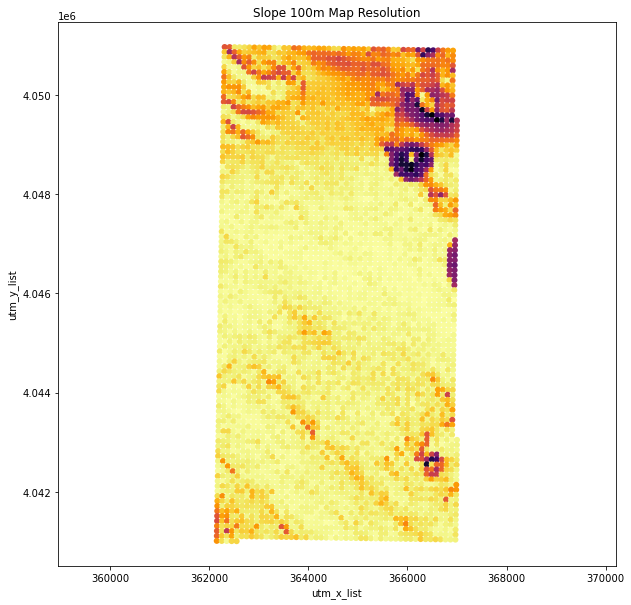

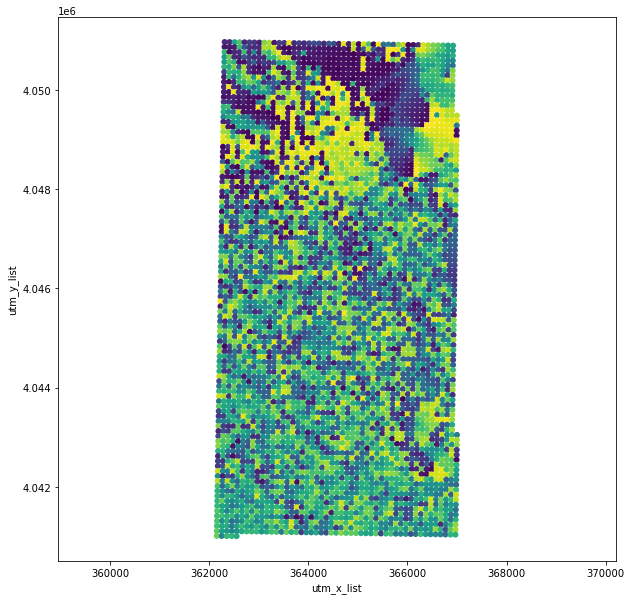

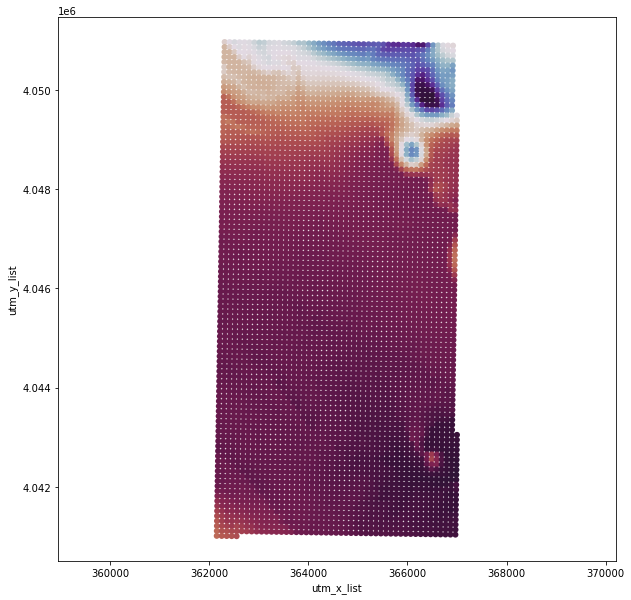

In [ ]:
fig,ax=plt.subplots(figsize=(10,10))
sns.scatterplot(
    bathy_sub_df.utm_x_list,
    bathy_sub_df.utm_y_list,
    bathy_sub_df.slope_list,
    palette='inferno_r',
    linewidth=0,
    legend=False)
plt.axis('equal')
plt.title('Slope %s'%str(resolution) + '0m Map Resolution')
#plt.savefig('/Users/zduguid/Desktop/fig/tmp.png')
#plt.close()

fig,ax=plt.subplots(figsize=(10,10))
sns.scatterplot(
    bathy_sub_df.utm_x_list,
    bathy_sub_df.utm_y_list,
    bathy_sub_df.orient_list,
    palette='viridis_r',
    linewidth=0,
    legend=False)
plt.axis('equal')
plt.title('Orientation %s'%str(resolution) + '0m Map Resolution')
#plt.savefig('/Users/zduguid/Desktop/fig/tmp.png')
#plt.close()

fig,ax=plt.subplots(figsize=(10,10))
sns.scatterplot(
    bathy_sub_df.utm_x_list,
    bathy_sub_df.utm_y_list,
    bathy_sub_df.depth_list,
    palette='twilight_shifted',
    linewidth=0,
    legend=False)
plt.axis('equal')
plt.title('Depth %s'%str(resolution) + '0m Map Resolution')
#plt.savefig('/Users/zduguid/Desktop/fig/tmp.png')
#plt.close()

In [ ]:
# bathy.plot_depth_map()
# bathy.plot_slope_map()
# bathy.plot_orientation_map()
# bathy.plot_three_factors()
bathy.plot_depth_contours()

In [ ]:
# # plot seafloor depth
# sns.set(font_scale = 1.5)
# fig, ax = plt.subplots(figsize=(15,8))
# ep.plot_bands(
#     -bathy, 
#     cmap='viridis_r',
#     title="Depth Map [m]",
#     ax=ax,
#     scale=False
# )

In [ ]:
def get_utm_coords_from_bathy_lat_lon(lat, lon): 
    """TODO
    """
    utm_pos  = utm.from_latlon(lat, lon)
    easting  = round(utm_pos[0],2)
    northing = round(utm_pos[1],2)
    zone     = utm_pos[2]
    return(easting, northing, zone)

get_utm_coords_from_bathy_lat_lon(bathy_l, bathy_b)

# bathy_l, bathy_r, bathy_b, bathy_t

In [ ]:

bathy[bathy>=0]=np.nan
bathy.shape

In [ ]:
scharr = np.array([[ +3 -3j,  +10    , +3 +3j],
                   [    -10j,   0    ,    +10j],
                   [ -3 -3j,  -10    , -3 +3j]]) / 32  # Gx + j*Gy

In [ ]:
bathy_grad = scipy.signal.convolve2d(bathy, scharr, boundary='symm', mode='same')/(np.max([delta_x,delta_y]))

In [ ]:
bathy_slope  = np.arctan(np.absolute(bathy_grad))*RAD_TO_DEG

In [ ]:
bathy_orient = np.angle(bathy_grad)*RAD_TO_DEG

## Plot Environment Data

In [ ]:
# sns.set(font_scale = 1.5)
# fig, ax = plt.subplots(2,3, figsize=(15,8), gridspec_kw={'height_ratios': [2, 1]})
# fig.subplots_adjust(hspace=.4)
# fig.subplots_adjust(wspace=.3)
# plt.suptitle(data['title'], fontweight='bold', fontsize=28)


# # plot seafloor depth
# ep.plot_bands(
#     -bathy, 
#     cmap='viridis_r',
#     title="Depth Map [m]",
#     ax=ax[0,0],
#     scale=False
# )


# # plot seafloor slope
# ep.plot_bands(
#     bathy_slope, 
#     cmap='inferno_r',
#     title='Gradiant [deg]',
#     ax=ax[0,1],
#     scale=False
# )


# # plot seafloor slope orientation 
# ep.plot_bands(
#     bathy_orient, 
#     cmap='twilight_shifted',
#     title='Orientation [deg]',
#     ax=ax[0,2],
#     scale=False
# )


# sns.kdeplot(-bathy.flatten(),       shade=True, ax=ax[1,0], linewidth=3)
# sns.kdeplot(bathy_slope.flatten(),  shade=True, ax=ax[1,1], linewidth=3)
# sns.kdeplot(bathy_orient.flatten(), shade=True, ax=ax[1,2], linewidth=3)
# ax[1,0].set_xlabel('Depth [m]')
# ax[1,1].set_xlabel('Slope [deg]')
# ax[1,2].set_xlabel('Orientation [deg]')
# xticks  = np.arange(bathy_w/data['num_ticks']/2, bathy_w, bathy_w/data['num_ticks'])
# xlabels = [data['ticks'] % np.round((bathy_r-bathy_l)*(i/bathy_w) + bathy_l, 5) for i in xticks]
# yticks  = np.arange(bathy_h/data['num_ticks']/2, bathy_h, bathy_h/data['num_ticks'])
# ylabels = [data['ticks'] % np.round((bathy_b-bathy_t)*(i/bathy_h) + bathy_t, 5) for i in yticks]


# # plot axis labels 
# for i in range(3):
#     ax[0,i].set_xticks(xticks)
#     ax[0,i].set_xticklabels(xlabels)
#     ax[0,i].set_yticks(yticks)
#     if i==0:
#         ax[0,i].set_yticklabels(ylabels)
#         ax[0,i].set_ylabel(data['ylabel'])
#         ax[1,i].set_ylabel('Kernel Density')
#     else:
#         ax[0,i].set_yticklabels(['' for _ in ylabels])
#     ax[0,i].set_xlabel(data['xlabel'])
#     ax[0,i].grid(linewidth=1, alpha=1, color='lavenderblush')
# plt.savefig('/Users/zduguid/Desktop/fig/tmp.png')
# print('>> Plotting Complete')
# plt.show()